In [1]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Layer, ReLU, LeakyReLU, Lambda
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import argparse

plt.rcParams.update({
    "font.family": "serif"
})
import importlib
%matplotlib notebook

In [2]:
file = h5py.File('Region_ZeroBias.hdf5', 'r')
#file = h5py.File('Hto2LLPto4b_MH-350_MFF-80.hdf5', 'r')
cyl = file.get('l1Region_cyl')
cart = file.get('l1Region_cart')
print((cyl.shape))

(1263, 576, 3)


In [3]:
test_frac = 0.2
val_frac = 0.2


def pt_cutoff(array,cutoff=200,size = 250):
    count = 0
    output = []
    for i in range(array.shape[0]):
        if count >= size: 
            break
        if np.max(array[i,:,0]) <= cutoff:
            output.append(array[i])
            count += 1
    output = np.asarray(output)
    output = output.reshape((output.shape[0],-1))
    return output

X_train, X_test = train_test_split(np.asarray(cyl), test_size=test_frac, shuffle=True)
X_train, X_val = train_test_split(X_train, test_size=val_frac)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

#X_test = pt_cutoff(np.asarray(cyl))
X_test = np.asarray(cyl)

norm_max = np.max(X_test)
norm_mean = np.mean(X_test)

def normalise(array):
    #array_mean = (np.mean(array,axis=1,keepdims=True))
    #array_max = np.abs(np.amax(array,axis=1,keepdims=True))
    #return (array - norm_mean)/(norm_max - norm_mean)
    return array/norm_max
    #return array


X_train = normalise(X_train.reshape((X_train.shape[0], -1)))
X_test = normalise(X_test.reshape((X_test.shape[0], -1)))
X_val = normalise(X_val.reshape((X_val.shape[0], -1)))
X_total = normalise(np.asarray(cyl).reshape((cyl.shape[0],-1)))




print(X_total.shape)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)



(808, 576, 3)
(253, 576, 3)
(202, 576, 3)
(1263, 1728)
(808, 1728)
(1263, 1728)
(202, 1728)


In [4]:
# Normalising the input data
#v_min = v.min(axis=(0, 1), keepdims=True)
#v_max = v.max(axis=(0, 1), keepdims=True)
#(v - v_min)/(v_max - v_min)

print(np.max(X_train))

1.0


## Defining the VAE Architecture

In [5]:
input_shape = X_train.shape[-1]
latent_dim = 2
num_nodes=[432,108,27,9]
print(input_shape)

1728


In [6]:
# Stochastic Latent Space Functions
from tensorflow.keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [49]:
# Encoder
inputs = Input(shape=(input_shape,))
h = Dense(num_nodes[0],use_bias=False)(inputs)
h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Dense(num_nodes[1], use_bias=False)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Dense(num_nodes[2], use_bias=False)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Dense(num_nodes[3], use_bias=False)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)
z = Lambda(sampling)([z_mean, z_log_sigma])

encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

encoder.summary()

#decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = Dense(num_nodes[3], use_bias=False)(latent_inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(num_nodes[2], use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(num_nodes[1], use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(num_nodes[0], use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
outputs = Dense(input_shape)(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae')
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 1728)]       0                                            
__________________________________________________________________________________________________
dense_55 (Dense)                (None, 432)          746496      input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 432)          1728        dense_55[0][0]                   
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 432)          0           batch_normalization_40[0][0]     
____________________________________________________________________________________________

In [50]:
# VAE Loss Function & VAE Compile

reconstruction_factor = input_shape

#reconstruction_loss = keras.losses.binary_crossentropy((inputs), (outputs))
mse = keras.losses.MeanSquaredError()
reconstruction_loss = mse(inputs,outputs)
reconstruction_loss *= reconstruction_factor
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [51]:
# Training the NN
EPOCHS = 20
BATCH_SIZE = 16

In [52]:
history = vae.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val),
                  #callbacks=callbacks
                 )

Epoch 1/20
51/51 [==============================] - 2s 36ms/step - loss: 41.9554 - val_loss: 1.1927
Epoch 2/20
51/51 [==============================] - 1s 25ms/step - loss: 3.9395 - val_loss: 1.5857
Epoch 3/20
51/51 [==============================] - 1s 21ms/step - loss: 2.3870 - val_loss: 1.4124
Epoch 4/20
51/51 [==============================] - 1s 21ms/step - loss: 1.7161 - val_loss: 1.1299
Epoch 5/20
51/51 [==============================] - 1s 22ms/step - loss: 1.4241 - val_loss: 0.9587
Epoch 6/20
51/51 [==============================] - 1s 22ms/step - loss: 1.1689 - val_loss: 0.8816
Epoch 7/20
51/51 [==============================] - 1s 21ms/step - loss: 0.9607 - val_loss: 0.8926
Epoch 8/20
51/51 [==============================] - 1s 21ms/step - loss: 0.8077 - val_loss: 0.8523
Epoch 9/20
51/51 [==============================] - 1s 21ms/step - loss: 0.7013 - val_loss: 0.8035
Epoch 10/20
51/51 [==============================] - 1s 22ms/step - loss: 0.6445 - val_loss: 0.5587
Epoch 11

<IPython.core.display.Javascript object>


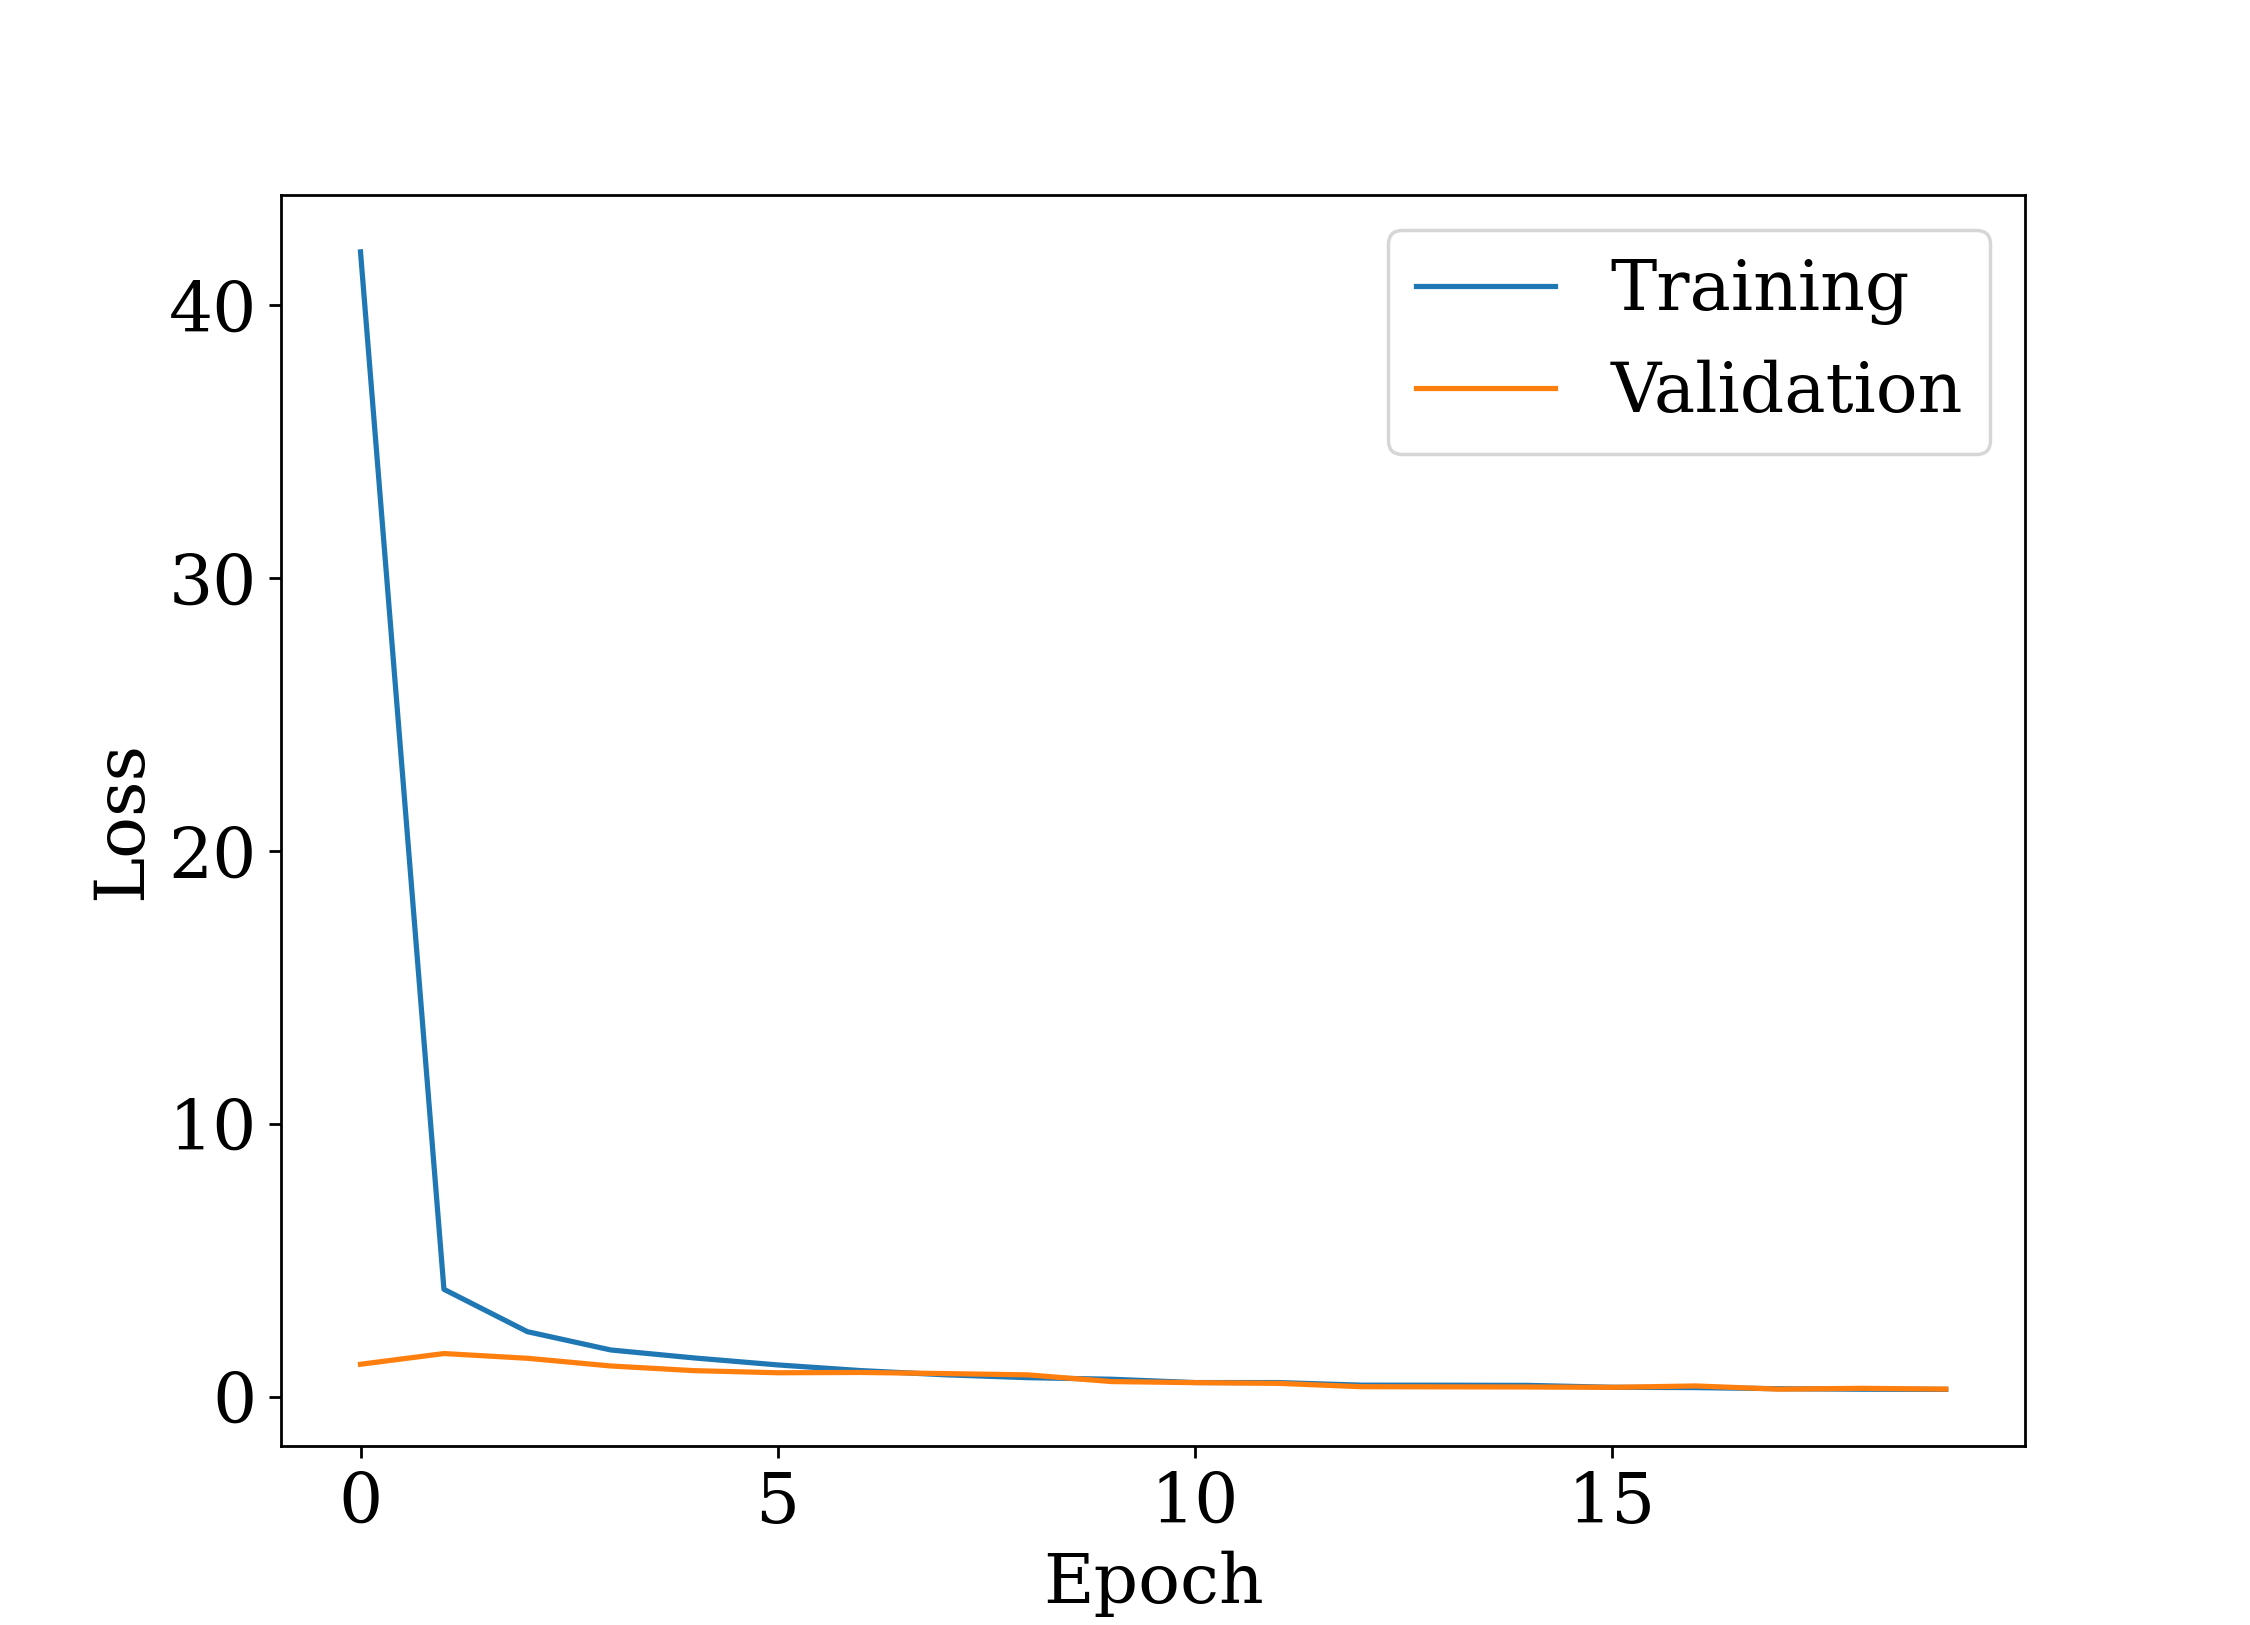

In [106]:
# Validation vs Training Loss


plt.figure(figsize=(9,6.5))
#plt.yscale("log")
plt.plot(history.history['loss'],label="Training")
plt.plot(history.history['val_loss'],label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("vae_EpochLossCurve.png")



In [22]:
# Save the model

encoder.save("vae_encoder")
vae.save("vae_total")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: vae_encoder\assets
INFO:tensorflow:Assets written to: vae_total\assets


In [62]:
# Testing the VAE

def kl_divergence(mu, log_var):
    return -0.5 * K.sum(1 + log_var - K.exp(log_var) - K.square(mu), axis=-1,)

def vae_loss_scores(encoder, X, vae):
    """Get the KL-divergence scores across from a trained VAE encoder.
 
    Parameters
    ===========
    encoder : TenorFlow model
        Encoder of the VAE
    
    vae: TensorFlow model
        The total encoded and decoded output (basically the model prediction)
    
    X : tensor
        data that KL-div. scores will be calculated from
    Returns
    ===========
    kls : numpy array
        Returns the KL-divergence scores as a numpy array
    """
    codings_mean, codings_log_var, codings = encoder.predict(X, batch_size=64)
    kls = np.array(kl_divergence(codings_mean, codings_log_var))
    #reconstruction_loss = np.array(keras.losses.binary_crossentropy(X, vae.predict(X)))
    mse = tf.keras.losses.MeanSquaredError()
    reconstruction_loss = mse(X,vae.predict(X)).numpy()
    return (kls + reconstruction_loss*input_shape)

bkg_loss = vae_loss_scores(encoder, X_test, vae)
print("bkg loss mean: " + str(np.mean(bkg_loss)))

np.save('vae_bkg_loss.npy',bkg_loss)

bkg loss mean: 0.24820642


In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [14]:
test_sample_size = 1000

# Cut the pt level of the testing data
#pt_cutoff = 100;

HInv_file = h5py.File('HInv.hdf5', 'r')
hinv_cyl = np.asarray(HInv_file.get('l1Region_cyl'))
#hinv_cyl = pt_cutoff(hinv_cyl)
hinv_cyl = normalise(hinv_cyl.reshape((hinv_cyl.shape[0], -1)))
#hinv_random_indices = np.random.choice(hinv_cyl.shape[0],size=test_sample_size)
#hinv_cyl = np.asarray([hinv_cyl[i] for i in hinv_random_indices])
print("hinv data shape: " + str(hinv_cyl.shape))

HLLPb_file = h5py.File('Hto2LLPto4b_MH-350_MFF-80.hdf5','r')
HLLPb_cyl = np.asarray(HLLPb_file.get('l1Region_cyl'))
HLLPb_cyl = normalise(HLLPb_cyl.reshape((HLLPb_cyl.shape[0], -1)))
print("HLLPb data shape: " + str(HLLPb_cyl.shape))

vqq_file = h5py.File('VToQQ-PT300.hdf5', 'r')
vqq_cyl = np.asarray(vqq_file.get('l1Region_cyl'))
#vqq_cyl = pt_cutoff(vqq_cyl)
vqq_cyl = normalise(vqq_cyl.reshape((vqq_cyl.shape[0],-1)))
#vqq_random_indices = np.random.choice(vqq_cyl.shape[0],size = test_sample_size)
#vqq_cyl = np.asarray([vqq_cyl[i] for i in vqq_random_indices])
print("vqq data shape: " + str(vqq_cyl.shape))

hinv data shape: (3000, 1728)
HLLPb data shape: (40000, 1728)
vqq data shape: (33847, 1728)


In [64]:
# Getting predictions and mse loss for anomalous data
hinv_loss = vae_loss_scores(encoder, hinv_cyl, vae)
print("Mean HInv Loss: " + str(np.mean(hinv_loss)))
np.save('vae_hinv_loss.npy',hinv_loss)

HLLPb_loss = vae_loss_scores(encoder, HLLPb_cyl, vae)
print("Mean HLLPb Loss: " + str(np.mean(HLLPb_loss)))
np.save('vae_hllpb_loss.npy',HLLPb_loss)

vqq_loss = vae_loss_scores(encoder, vqq_cyl, vae)
print("Mean VQQ Loss: " + str(np.mean(vqq_loss)))
np.save('vae_vqq_loss.npy',vqq_loss)


Mean HInv Loss: 1.3449303
Mean HLLPb Loss: 0.86743975
Mean VQQ Loss: 0.23516095


In [74]:
# Getting data ready for plotting
labels = ["Bkg", "HtoInv", "VToQQ","Hto2LLPto4b"]
losses = np.asarray([bkg_loss, hinv_loss, vqq_loss,HLLPb_loss])

C:\Users\sandi.LAPTOP-BIPVBEES\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


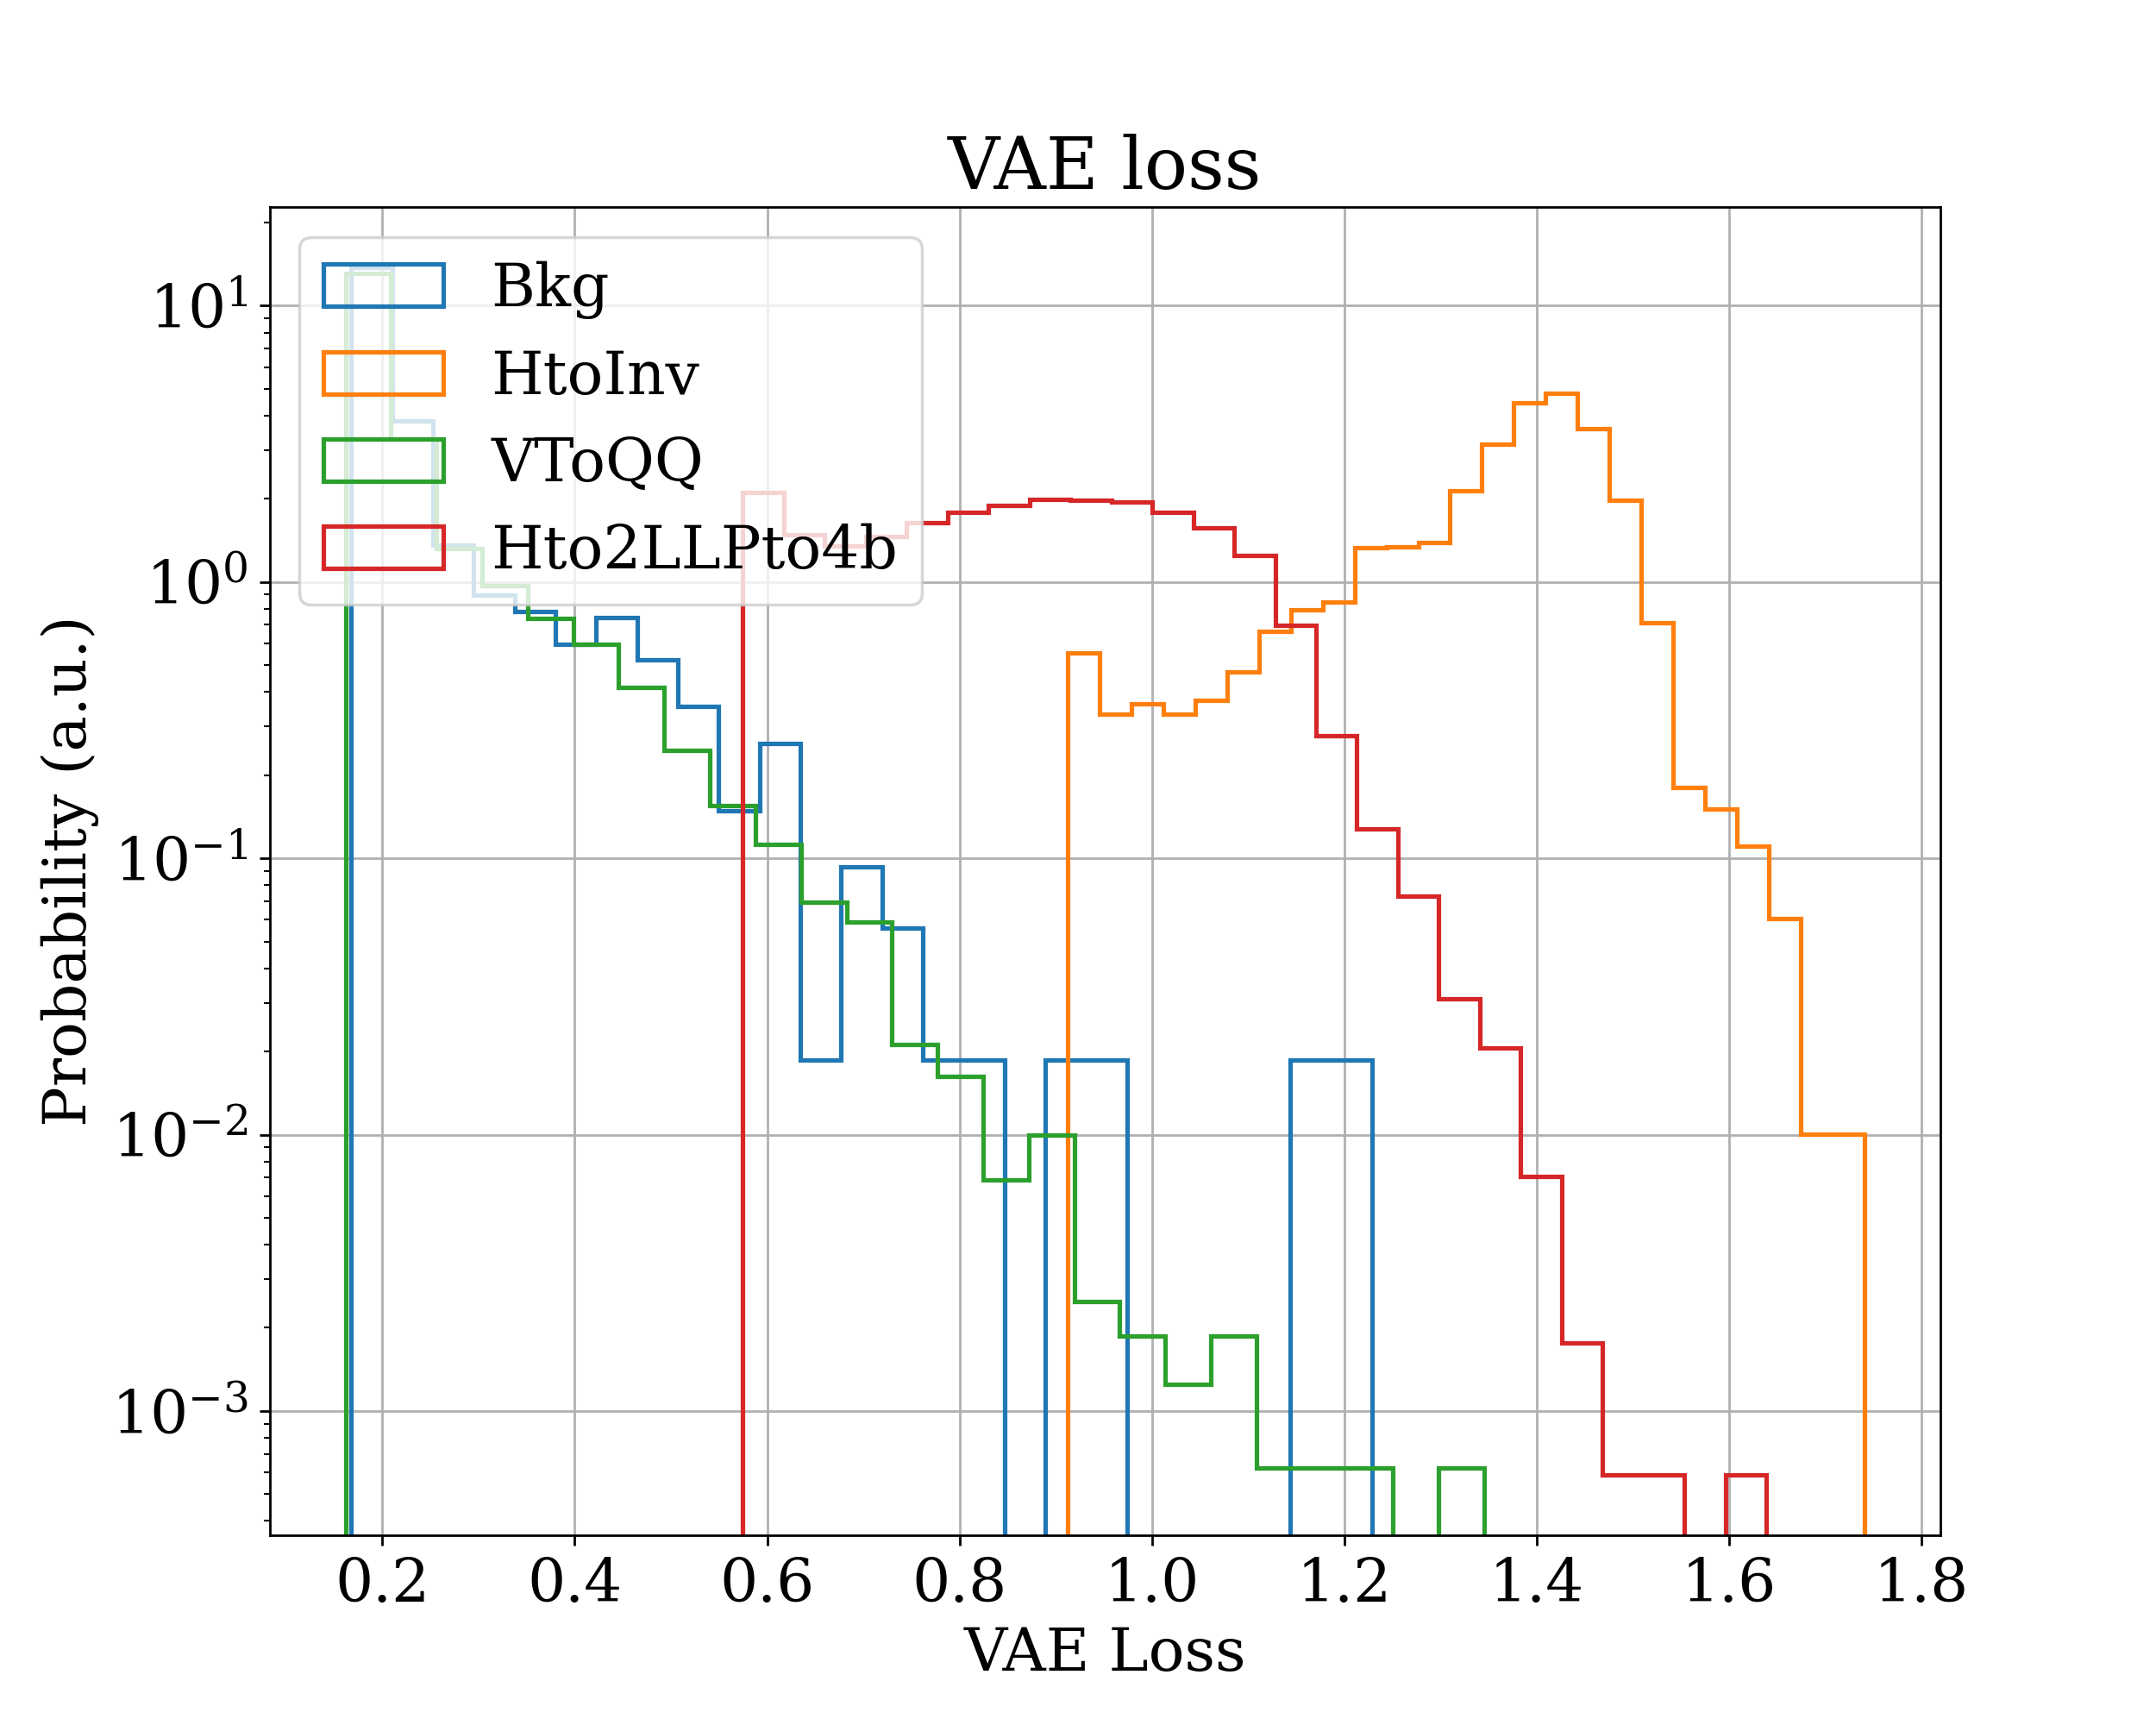

In [90]:
# Plotting MSE Loss histogram

plt.rcParams.update({'font.size': 20})

bin_size=25

plt.figure(figsize=(10,8))
#plt.hist(losses[0], bins=bin_size, label=labels[0], density = True, histtype='step', fill=False, linewidth=1.5)
for i, label in enumerate(labels):
    plt.hist(losses[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel("VAE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.title('VAE loss')
plt.legend(loc='best')
plt.show()
plt.savefig("vae_loss.png")


<IPython.core.display.Javascript object>


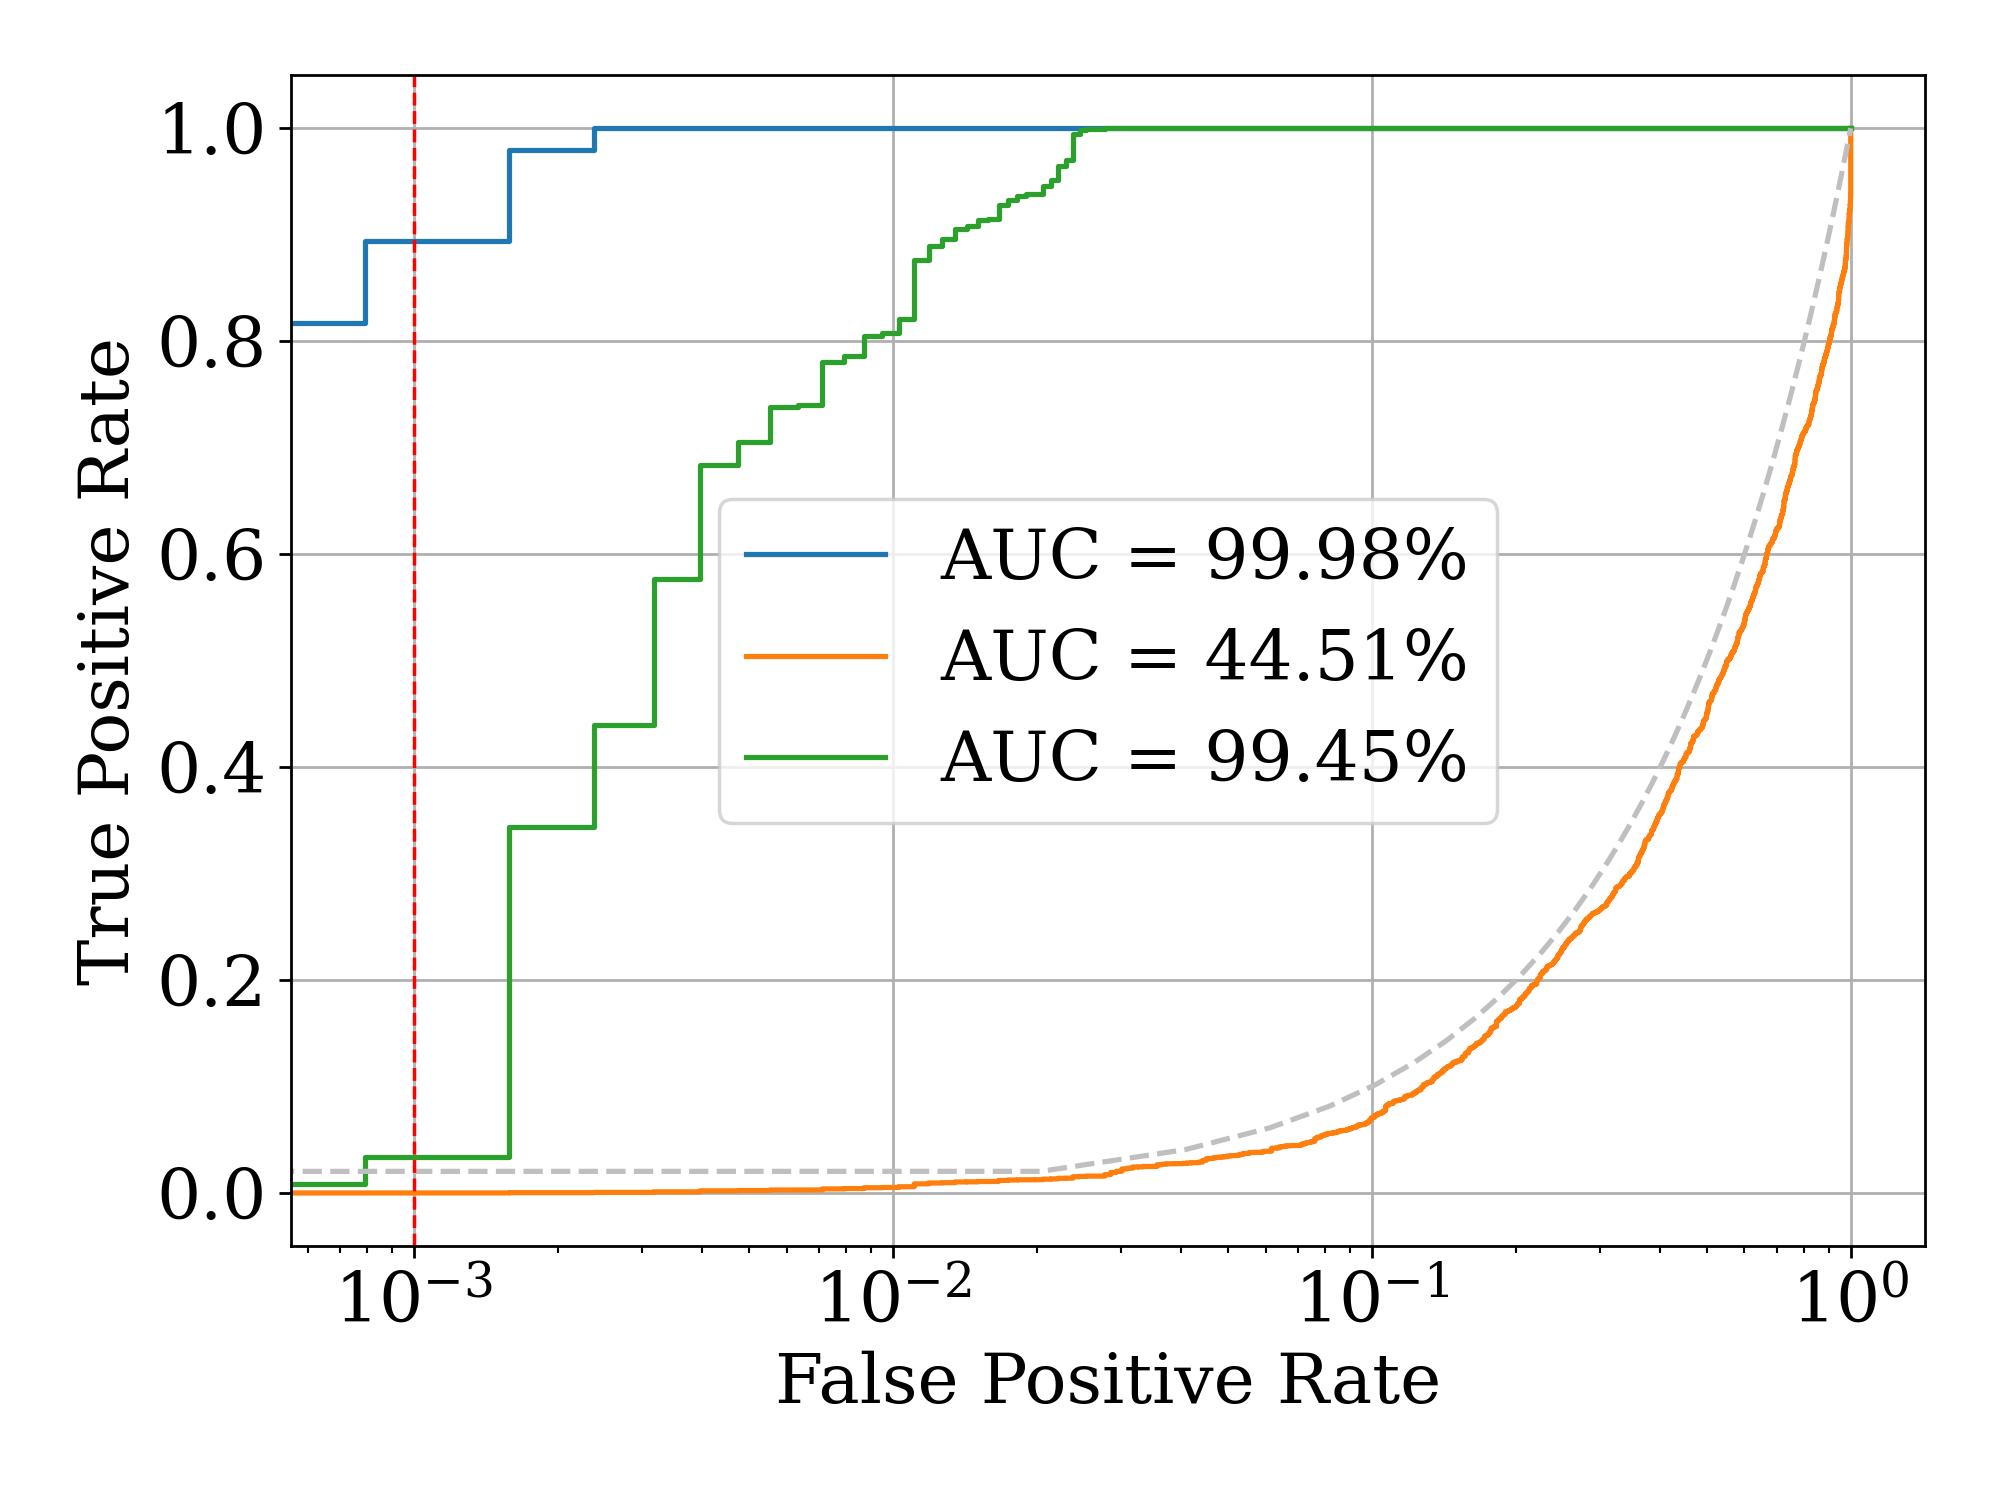

In [91]:
target_background = np.zeros(losses[0].shape[0])

plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(losses[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((losses[i], losses[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)
    
    plt.plot(fpr_loss, tpr_loss, "-", label='AUC = %.2f%%'%(auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    #plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection performance
#plt.title("VAE ROC")
plt.show()
plt.savefig("vae_ROC.png")

<IPython.core.display.Javascript object>


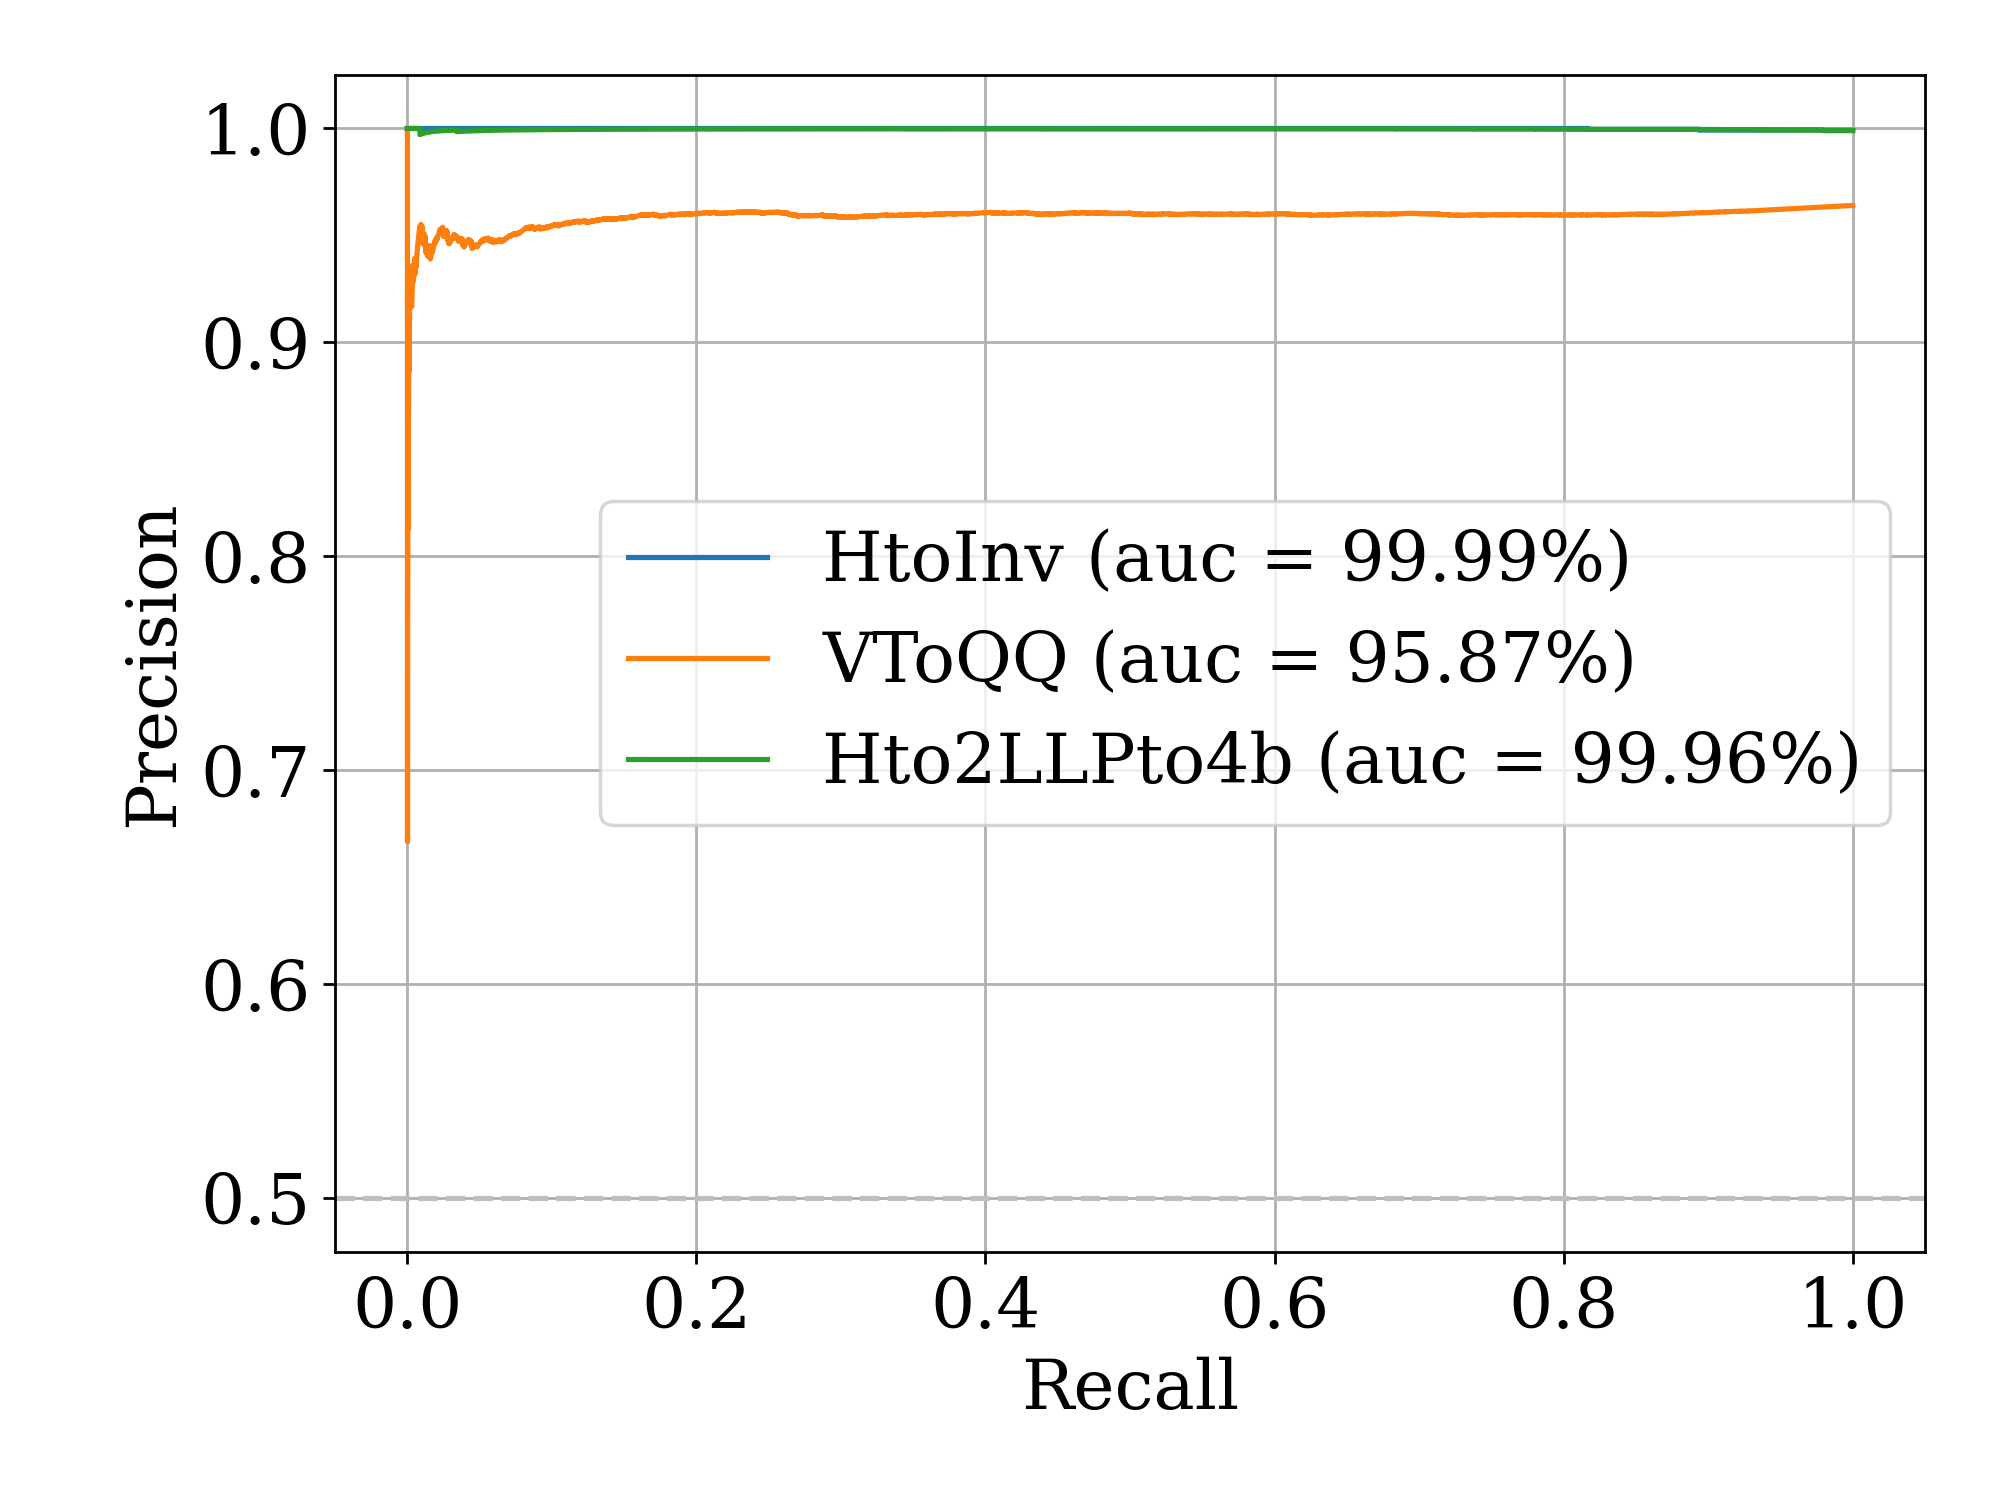

In [92]:
# Precision Recall Plot
target_background = np.zeros(losses[0].shape[0])

plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(losses[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((losses[i], losses[0]))

    precision, recall, thresholds = precision_recall_curve(trueVal, predVal_loss)

    auc_loss = auc(recall, precision)
    
    plt.plot(recall, precision, "-", label='%s (auc = %.2f%%)'%(label,auc_loss*100.), linewidth=1.5)
    
    #plt.semilogx()
    #plt.semilogy()
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    #plt.legend(loc='center right')
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
#plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axhline(0.5,linestyle='dashed',color='0.75')
#plt.axvline(0.01, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection performance
#plt.title("VAE Precision-Recall")
plt.show()
plt.savefig("vae_pr.png")

In [71]:
# Plotting the Latent variables

i = 2

hinv_latent = np.asarray(encoder.predict(hinv_cyl))[i,:,:]
vqq_latent = np.asarray(encoder.predict(vqq_cyl))[i,:,:]
bkg_latent = np.asarray(encoder.predict(X_total))[i,:,:]
hllpb_latent = np.asarray(encoder.predict(HLLPb_cyl))[i,:,:]

np.save("vae_hinv_latent.npy",hinv_latent)
np.save("vae_vqq_latent.npy",vqq_latent)
np.save("vae_bkg_latent.npy",bkg_latent)
np.save("vae_hllpb_latent.npy",hllpb_latent)


<IPython.core.display.Javascript object>


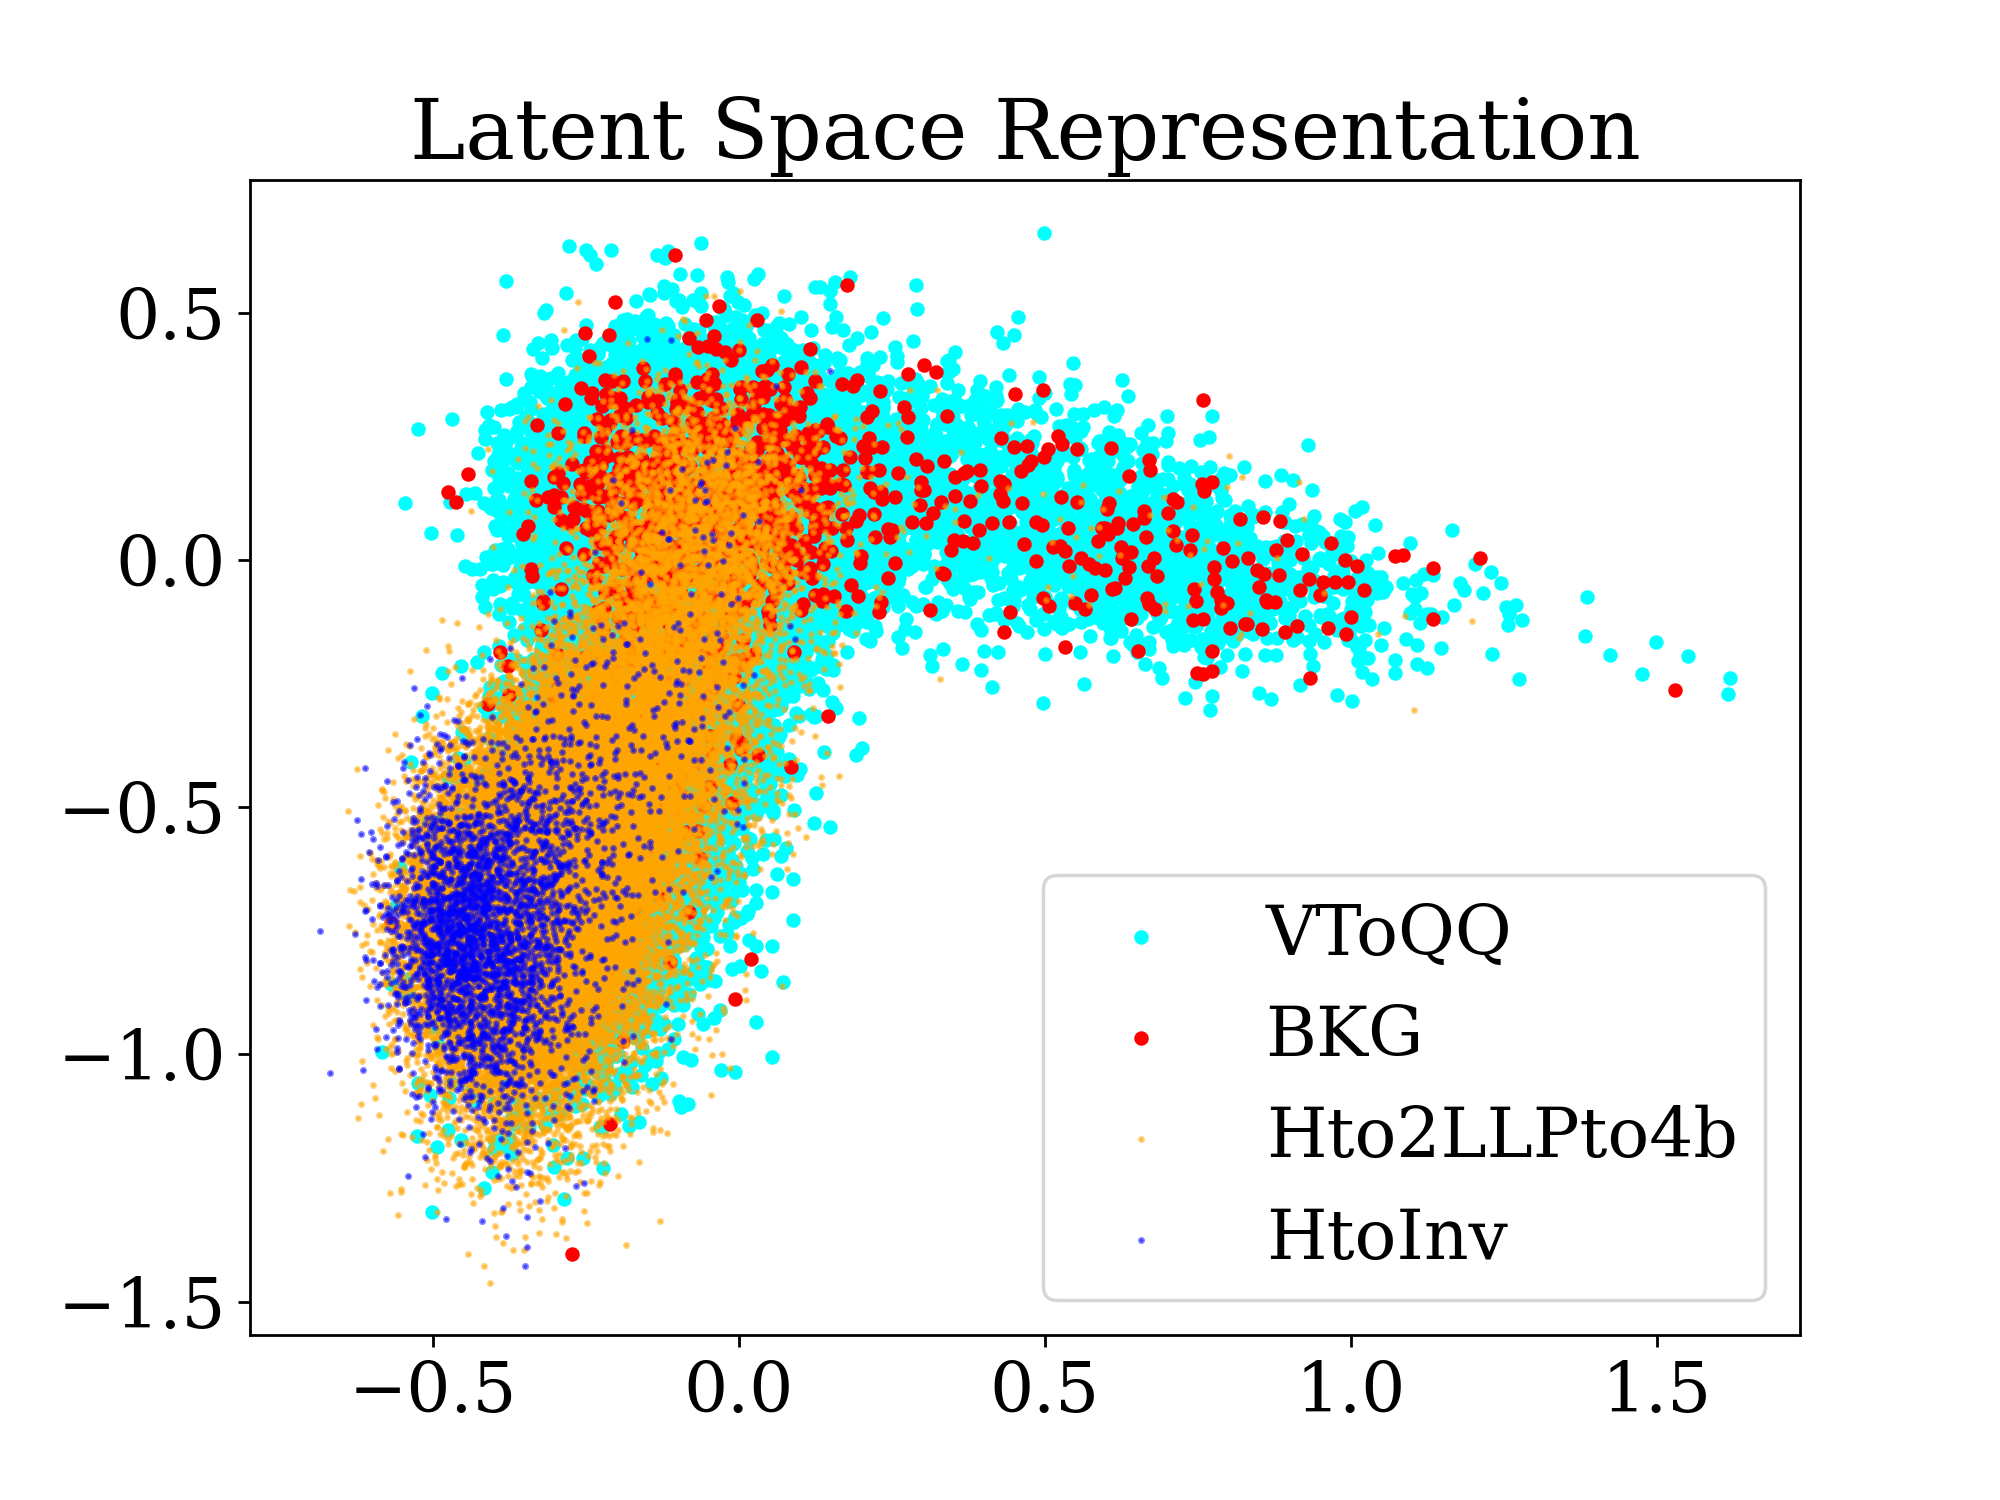

In [94]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
#ax.set_xscale('log')
#ax.set_yscale('log')

ax.scatter(vqq_latent[:,0],vqq_latent[:,1],c="cyan",label="VToQQ",s=10)
ax.scatter(bkg_latent[:,0],bkg_latent[:,1],c="red",label="BKG",s=10)
ax.scatter(hllpb_latent[:,0],hllpb_latent[:,1],c="orange",label="Hto2LLPto4b",alpha=0.5,s=1)
ax.scatter(hinv_latent[:,0],hinv_latent[:,1],c="blue",label="HtoInv",alpha=0.5,s=1)
ax.legend(loc='best')
#ax.set_ylim([-50,50])
ax.set_title("Latent Space Representation")
plt.savefig("vae_latent_space.png")